In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
import os

In [0]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [0]:
learning_rate= 0.0002
batch_size = 100
num_epochs = 30
n_noise = 100

In [0]:
sample_dir = 'samples'

if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.MNIST(root='../../data/', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21531966.87it/s]                            


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 332740.88it/s]
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5252422.88it/s]                           
8192it [00:00, 130484.15it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def to_onehot(y, num_classes=10):
  y = y.long().cpu()    # input y.shape = (batch.size, 1)
  out = torch.LongTensor(y.size(0), num_classes)
  out.zero_()
  out.scatter_(1, y, 1)
  return out.float().to(device) #

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer1 = nn.Sequential(nn.Linear(28*28 + 10, 512),
                                nn.ReLU(True),
                                nn.Linear(512, 256),
                                nn.ReLU(True),
                                nn.Linear(256, 1),
                                nn.Sigmoid())
  def forward(self, x, c):
    x = torch.cat([x, c], 1)
    out = self.layer1(x)
    return out
  
###################################################################
###################################################################

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layer1 = nn.Sequential(nn.Linear(n_noise + 10, 256),
                                nn.LeakyReLU(0.2, True),
                                nn.Linear(256, 512),
                                nn.LeakyReLU(0.2, True),
                                nn.Linear(512, 28*28),
                                nn.Tanh())
    
  def forward(self, x, c):
    x = torch.cat([x, c], 1)
    out = self.layer1(x)
    return out

In [0]:
D = Discriminator().to(device)
G = Generator().to(device)

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))

def zero_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()
  
def norm(images):
  return images*2 - 1
  
def denorm(images):
  images = (images+1)/2
  return images.clamp(0,1)


In [10]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(data_loader):
    images = images.view(images.size(0), -1).to(device)
    images = norm(images)
    labels = labels.view(labels.size(0),-1).to(device)  # (1, batch_size) -> (batch_size, 1)
    labels = to_onehot(labels)
    
    
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)
    #===================================================
    #                 Train Discriminator
    # ==================================================
    outputs = D(images, labels)
    d_loss_real = criterion(outputs, real_labels)
    
    z = torch.randn(images.size(0), n_noise).to(device)
    fake_image = G(z, labels)
    outputs = D(fake_image, labels)
    d_loss_fake = criterion(outputs, fake_labels)
    
    
    d_loss = d_loss_real + d_loss_fake
    
    zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    #===================================================
    #                 Train Generator
    # ==================================================
    z = torch.randn(images.size(0), n_noise).to(device)
    fake_image = G(z, labels)
    outputs_fake = D(fake_image, labels)
    g_loss = criterion(outputs_fake, real_labels)
    
    zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    
    if (i+1) % 200 == 0:
      print('Epoch [{}/{}], Step [{}/{}], d_loss [{:.4f} : {:.4f}], g_loss : {:.4f}'
            .format(epoch, num_epochs, i+1, len(data_loader), d_loss_real.item(), d_loss_fake.item(), g_loss.item()))
      
    
  fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
  save_image(denorm(fake_image), os.path.join(sample_dir, 'fake_images={}.png'.format(str(epoch).zfill(3))))

Epoch [0/30], Step [200/600], d_loss [0.0338 : 0.2925], g_loss : 2.1323
Epoch [0/30], Step [400/600], d_loss [0.9267 : 0.0359], g_loss : 1.4604
Epoch [0/30], Step [600/600], d_loss [0.9755 : 0.0331], g_loss : 1.1510
Epoch [1/30], Step [200/600], d_loss [0.2438 : 0.1429], g_loss : 2.2030
Epoch [1/30], Step [400/600], d_loss [0.1476 : 0.1885], g_loss : 1.6935
Epoch [1/30], Step [600/600], d_loss [0.0977 : 0.0912], g_loss : 1.7650
Epoch [2/30], Step [200/600], d_loss [0.0289 : 0.4207], g_loss : 5.1486
Epoch [2/30], Step [400/600], d_loss [0.2913 : 0.0419], g_loss : 2.4478
Epoch [2/30], Step [600/600], d_loss [0.0956 : 0.2262], g_loss : 2.6975
Epoch [3/30], Step [200/600], d_loss [0.2303 : 0.0441], g_loss : 2.9437
Epoch [3/30], Step [400/600], d_loss [0.4806 : 0.0118], g_loss : 3.1233
Epoch [3/30], Step [600/600], d_loss [0.1068 : 0.2470], g_loss : 4.4419
Epoch [4/30], Step [200/600], d_loss [0.0404 : 0.2046], g_loss : 4.4504
Epoch [4/30], Step [400/600], d_loss [0.3010 : 0.0396], g_loss :

In [0]:
from matplotlib.pyplot import imshow, imsave
import numpy as np
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(device)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(device)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

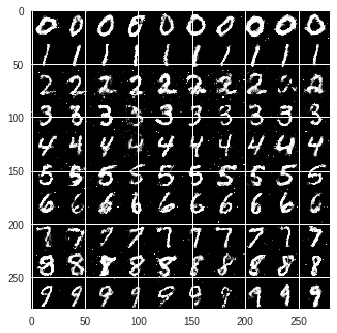

In [12]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')